In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import math
import datetime as dt
import time
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError


import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:

def fetch_latest_binance_data(symbol="BTCUSDT", interval="1d", start_date=None):
    """
    Fetch OHLCV data from Binance starting from a given date.
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": int(pd.Timestamp(start_date).timestamp() * 1000),
        "limit": 1000  # max daily candles
    }
    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame(data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Volume", "Number of Trades",
        "Taker Buy Base", "Taker Buy Quote", "Ignore"
    ])
    
    df["Date"] = pd.to_datetime(df["Open Time"], unit='ms')
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]  # You can add Adj Close separately
    df[["Open", "High", "Low", "Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Volume"]].astype(float)

    return df

In [3]:
btcdf=pd.read_csv("oct15.csv")

In [4]:
btcdf.drop(columns=["Adj Close"], inplace=True)

In [5]:
print('Null Values:',btcdf.isnull().values.sum())

Null Values: 0


In [6]:
btcdf.describe()

,Open,High,Low,Close,Volume
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03
mean,33391.251534,34168.366423,32534.152445,33401.806876,3.288677e+10
std,13256.991133,13629.117942,12801.861188,13235.848643,2.041839e+10
min,11322.123047,11386.261719,11223.012695,11322.123047,5.331173e+09
25%,22621.914551,23124.684570,22154.839844,22635.090820,1.978072e+10
50%,29795.587890,30333.520508,29264.986328,29795.547851,2.956358e+10
75%,42961.791016,43907.089843,41992.264649,42897.068359,3.966625e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


In [7]:
#sns.pairplot(btcdf)

In [8]:
btcdf['Date'] = pd.to_datetime(btcdf['Date'])
last_date = btcdf['Date'].max() + pd.Timedelta(days=1)

# Fetch and append data
new_data = fetch_latest_binance_data(start_date=last_date)
btcdf_updated = pd.concat([btcdf, new_data], ignore_index=True)
btcdf_updated = btcdf_updated.drop_duplicates(subset='Date', keep='first').reset_index(drop=True)

# Finally, convert to date (optional)
btcdf_updated['Date'] = pd.to_datetime(btcdf_updated['Date']).dt.date

In [9]:
btcdf_updated.to_csv("btc_updated.csv", index=False)

# Or reassign it for modeling
btcdf = btcdf_updated.copy()

In [10]:
sd = btcdf.iloc[0, 0]
ed = btcdf.iloc[-1, 0]

print('Starting Date',sd)
print('Ending Date',ed)



Starting Date 2020-10-15
Ending Date 2025-10-03


In [11]:
closedf = btcdf[['Date','Close']]
print('Shape of close dataframe:',closedf.shape)

Shape of close dataframe: (1815, 2)


In [12]:
sd = pd.to_datetime(sd)
ed = pd.to_datetime(ed)
closedf = btcdf_updated[['Date', 'Close']].copy()  # <-- add .copy() here
closedf['Date'] = pd.to_datetime(closedf['Date'])
closedf = closedf[(closedf['Date']>= sd)
                    & (closedf['Date'] <= ed)]
print('Total daily BTC close price for testing:',closedf.shape[0])

closedf_copy = closedf.copy()

Total daily BTC close price for testing: 1815


In [13]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1815, 1)


In [14]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data, test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print('Train Data:', train_data.shape)
print('Test Data:',test_data.shape)

Train Data: (1452, 1)
Test Data: (363, 1)


In [15]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [16]:
time_step = 15
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (1436, 15)
y_train: (1436,)
x_test: (347, 15)
y_test: (347,)


In [17]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (1436, 15, 1)
x_test: (347, 15, 1)


In [18]:
def train_model(x_train, y_train, x_test, y_test,neurons,
                     dropout_prob,
                     activation,
                     batch_size,
                     lr):
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam

    model = Sequential([
        Input(shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(neurons, activation=activation),
        Dropout(dropout_prob),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics=[
                    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                    tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    return model, history


In [19]:
def plot_loss_accuracy(history, title):
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    rmse = history.history.get('rmse', [])
    val_rmse = history.history.get('val_rmse', [])
    mape = history.history.get('mape', [])
    val_mape = history.history.get('val_mape', [])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Loss
    axs[0].plot(loss, label='Train Loss', color='red')
    axs[0].plot(val_loss, label='Val Loss', color='blue')
    axs[0].set_title('Loss (MSE) - ' + title)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('MSE')
    axs[0].legend()

    # Plot RMSE
    axs[1].plot(rmse, label='Train RMSE', color='green')
    axs[1].plot(val_rmse, label='Val RMSE', color='orange')
    axs[1].set_title('Root Mean Squared Error - ' + title)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('RMSE')
    axs[1].legend()

    # Plot MAPE
    axs[2].plot(mape, label='Train MAPE', color='purple')
    axs[2].plot(val_mape, label='Val MAPE', color='cyan')
    axs[2].set_title('Mean Absolute Percentage Error - ' + title)
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('MAPE (%)')
    axs[2].legend()

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def evaluation(model, x_train, y_train, x_test, y_test, scaler):
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance

    # Predict (scaled)
    train_pred = model.predict(x_train, verbose=0)
    test_pred  = model.predict(x_test,  verbose=0)

    # Inverse-scale to price
    train_pred_i = scaler.inverse_transform(train_pred)
    test_pred_i  = scaler.inverse_transform(test_pred)
    ytrain_i     = scaler.inverse_transform(y_train.reshape(-1,1))
    ytest_i      = scaler.inverse_transform(y_test.reshape(-1,1))

    # Safe clips for deviance metrics (require >0)
    eps = 1e-8
    ytest_pos      = np.clip(ytest_i,      eps, None)
    test_pred_pos  = np.clip(test_pred_i,  eps, None)
    ytrain_pos     = np.clip(ytrain_i,     eps, None)
    train_pred_pos = np.clip(train_pred_i, eps, None)

    def mape(y, yhat):
        mask = np.abs(y) > eps
        return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask]))) if mask.any() else float("nan")

    def smape(y, yhat):
        return float(2*np.mean(np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + eps)))

    metrics = {
        "Metric": [
            "RMSE","MSE","MAE","MAPE","sMAPE","R²","Explained Variance","Gamma Deviance","Poisson Deviance"
        ],
        "Train": [
            float(np.sqrt(mean_squared_error(ytrain_i, train_pred_i))),
            float(mean_squared_error(ytrain_i, train_pred_i)),
            float(mean_absolute_error(ytrain_i, train_pred_i)),
            mape(ytrain_i, train_pred_i),
            smape(ytrain_i, train_pred_i),
            float(r2_score(ytrain_i, train_pred_i)),
            float(explained_variance_score(ytrain_i, train_pred_i)),
            float(mean_gamma_deviance(ytrain_pos, train_pred_pos)),
            float(mean_poisson_deviance(ytrain_pos, train_pred_pos)),
        ],
        "Test": [
            float(np.sqrt(mean_squared_error(ytest_i, test_pred_i))),
            float(mean_squared_error(ytest_i, test_pred_i)),
            float(mean_absolute_error(ytest_i, test_pred_i)),
            mape(ytest_i, test_pred_i),
            smape(ytest_i, test_pred_i),
            float(r2_score(ytest_i, test_pred_i)),
            float(explained_variance_score(ytest_i, test_pred_i)),
            float(mean_gamma_deviance(ytest_pos, test_pred_pos)),
            float(mean_poisson_deviance(ytest_pos, test_pred_pos)),
        ]
    }

    results_df = pd.DataFrame(metrics)
    return results_df, ytest_i, test_pred_i


Testing: activation=tanh, neurons=120, dropout=0, batch=32, lr=0.001


2025-10-04 02:28:06.185248: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-04 02:28:06.185273: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-04 02:28:06.185278: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-04 02:28:06.185444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-04 02:28:06.185688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-04 02:28:06.885352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-10-04 02:28:06.922837: E t

               Metric         Train          Test
0                RMSE  1.520974e+03  2.157081e+03
1                 MSE  2.313362e+06  4.652997e+06
2                 MAE  1.072798e+03  1.589250e+03
3                MAPE  2.771509e-02  1.652587e-02
4               sMAPE  2.731212e-02  1.649620e-02
5                  R²  9.908071e-01  9.723757e-01
6  Explained Variance  9.920603e-01  9.725131e-01
7      Gamma Deviance  1.329206e-03  5.241674e-04
8    Poisson Deviance  5.185653e+01  4.894863e+01


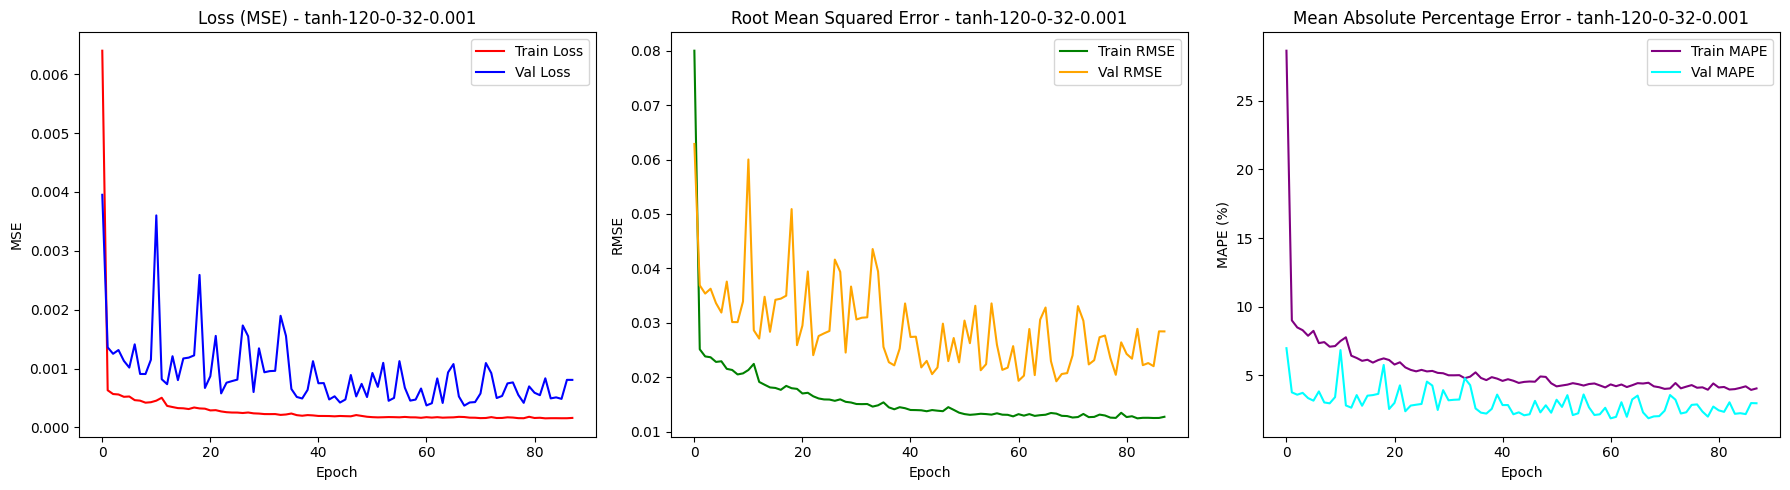

Best Config:{'activation': 'tanh', 'neurons': 120, 'dropout': 0, 'batch_size': 32, 'lr': 0.001}
Best Test MSE: 4652997.0427
final table :                Metric         Train          Test activation  neurons  \
0                RMSE  1.520974e+03  2.157081e+03       tanh      120   
1                 MSE  2.313362e+06  4.652997e+06       tanh      120   
2                 MAE  1.072798e+03  1.589250e+03       tanh      120   
3                MAPE  2.771509e-02  1.652587e-02       tanh      120   
4               sMAPE  2.731212e-02  1.649620e-02       tanh      120   
5                  R²  9.908071e-01  9.723757e-01       tanh      120   
6  Explained Variance  9.920603e-01  9.725131e-01       tanh      120   
7      Gamma Deviance  1.329206e-03  5.241674e-04       tanh      120   
8    Poisson Deviance  5.185653e+01  4.894863e+01       tanh      120   

   dropout  batch_size     lr  training_time_sec  
0        0          32  0.001          32.615976  
1        0          32  0.001

In [21]:
neurons_set = [x_train.shape[1] * f for f in [8]] #can add more
dropout_prob_set = [0]
activation_set = ['tanh']
batch_size_set = [32]
lr_set = [0.001]

best_mse = float('inf')
best_config = None
best_model = None
all_results = []
for neurons in neurons_set:
    for batch_size in batch_size_set:
        for dropout_prob in dropout_prob_set:
            for lr in lr_set:
                for activation in activation_set:
                    print(f"Testing: activation={activation}, neurons={neurons}, dropout={dropout_prob}, batch={batch_size}, lr={lr}")
                    start_time = time.time()
                    model, history = train_model(x_train, y_train, x_test, y_test,neurons, dropout_prob, activation, batch_size, lr)
                    end_time = time.time()
                    training_time = end_time - start_time
                    results_df, _, _ = evaluation(model, x_train, y_train, x_test, y_test, scaler)
                    print(results_df)
                    plot_loss_accuracy(history, title=f'{activation}-{neurons}-{dropout_prob}-{batch_size}-{lr}')
                    test_mse = results_df.loc[results_df['Metric'] == 'MSE', 'Test'].values[0]

                    # Track best model
                    if test_mse < best_mse:
                        best_mse = test_mse
                        best_config = {
                            'activation': activation,
                            'neurons': neurons,
                            'dropout': dropout_prob,
                            'batch_size': batch_size,
                            'lr': lr
                        }
                        best_model = model

                    # Store results for comparison
                    config_result = results_df.copy()
                    config_result['activation'] = activation
                    config_result['neurons'] = neurons
                    config_result['dropout'] = dropout_prob
                    config_result['batch_size'] = batch_size
                    config_result['lr'] = lr
                    config_result['training_time_sec'] = training_time
                    all_results.append(config_result)


final_results = pd.concat(all_results, ignore_index=True)
print(f"Best Config:{best_config}")
print(f"Best Test MSE: {best_mse:.4f}")
best_model.save("best_btc_model.keras")
final_results.to_csv("all_model_results.csv", index=False)
print(f"final table : {final_results}")

In [22]:
model = best_model

In [23]:
x_last = closedf[-time_step:].reshape(1, time_step, 1)  # closedf is your scaled array
next_day_scaled = model.predict(x_last, verbose=0)
next_day_close_forecast = float(scaler.inverse_transform(next_day_scaled)[0,0])

print(f"[Forecast] Next-day BTC close (price): {next_day_close_forecast:.2f}")


[Forecast] Next-day BTC close (price): 122182.00


In [24]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict.shape, test_predict.shape
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

11/11 [==============================] - 0s 3ms/step


In [25]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]= train_predict
print('Train Predicted Data:', trainPredictPlot.shape)

testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1,:]= test_predict
print('Test Predicted Data:', testPredictPlot.shape)

names = cycle(['Actual Close Price:', 'Train Predicted Close Price', 'Test Predicted Close Price'])

plotdf = pd.DataFrame({'date': closedf_copy['Date'],
                      'actual_close':closedf_copy['Close'],
                      'train_predicted_close':trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close':testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf, x=plotdf['date'], y=[plotdf['actual_close'], plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
                 labels={'value':'BTC Price','date':'Date'})

fig.update_layout(title_text='BTC Close Price: Actual VS Prediction',
                  font_size=15, font_color='Black', plot_bgcolor='white')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()
fig.write_html("btc_close_actual_chart.html")
fig.write_image("btc_close_actual_chart.png")

Train Predicted Data: (1815, 1)
Test Predicted Data: (1815, 1)


In [26]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array
First_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        First_output.extend(yhat.tolist())
        i=i+1
        
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        First_output.extend(yhat.tolist())
        i=i+1
        
print('Predicted BTC Close Price for next coming days:', len(First_output))

Predicted BTC Close Price for next coming days: 30


In [27]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1, time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [28]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()

last_actual_days_close_price= temp_mat
next_predicted_days_close_price=temp_mat

last_actual_days_close_price[0:time_step+1]=scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_close_price[time_step+1:]=scaler.inverse_transform(np.array(First_output).reshape(1,-1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_actual_days_close_price': last_actual_days_close_price,
    'next_predicted_days_close_price': next_predicted_days_close_price
})


fig = px.line(new_pred_plot, x=new_pred_plot.index, y=[new_pred_plot['last_actual_days_close_price'],
                                                      new_pred_plot['next_predicted_days_close_price']],
                 labels={'value':'BTC Price','index':'Days'})

fig.add_vline(x=time_step, line_dash="dash", line_color="black")
fig.update_layout(title_text='LSTM BTC CLOSE PREDICTION',
                  font_size=15, font_color='Black', plot_bgcolor='white')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_traces(selector=dict(name='Actual Close Price:'), line=dict(dash='dot'))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()
fig.write_html("btc_close_prediction_chart.html")
fig.write_image("btc_close_prediction_chart.png")

In [29]:
print(new_pred_plot)

    last_actual_days_close_price  next_predicted_days_close_price
0                  115632.380000                    115632.380000
1                  115685.630000                    115685.630000
2                  115232.290000                    115232.290000
3                  112650.990000                    112650.990000
4                  111998.800000                    111998.800000
5                  113307.000000                    113307.000000
6                  108994.490000                    108994.490000
7                  109643.460000                    109643.460000
8                  109635.850000                    109635.850000
9                  112163.950000                    112163.950000
10                 114311.960000                    114311.960000
11                 114048.930000                    114048.930000
12                 118594.990000                    118594.990000
13                 120529.350000                    120529.350000
14        

In [30]:
# === FINAL CELL: save forecast + metrics and print to logs ===
import os, json, math, datetime as dt
import pandas as pd  # <- needed in this cell

# 1) Recompute metrics (price scale) for the chosen/best model
results_df, _, _ = evaluation(model, x_train, y_train, x_test, y_test, scaler)

# helper to convert to clean floats for JSON
def _f(x):
    try:
        v = float(x)
        return v if math.isfinite(v) else None
    except Exception:
        return None

# 2) Collect Test metrics as plain floats
metrics_test = {k: _f(v) for k, v in results_df.set_index("Metric")["Test"].items()}

# 3) Target = next daily close after last observed date
last_obs_date = pd.to_datetime(closedf_copy["Date"].max())
target_close_date_utc = (last_obs_date + pd.Timedelta(days=1)).date().isoformat()
run_ts_utc = dt.datetime.utcnow().replace(microsecond=0).isoformat()

payload = {
    "symbol": "BTCUSDT",
    "horizon": "next_daily_close",
    "run_ts_utc": run_ts_utc,
    "target_close_date_utc": target_close_date_utc,
    "forecast_close": _f(next_day_close_forecast),  # must already be computed earlier
    "metrics_h1": metrics_test
}

# 4) Write files
os.makedirs("out", exist_ok=True)

with open("out/daily_forecast.json", "w") as f:
    json.dump(payload, f, indent=2)

row = {
    "run_ts_utc": run_ts_utc,
    "target_close_date_utc": target_close_date_utc,
    "symbol": "BTCUSDT",
    "forecast_close": _f(next_day_close_forecast),
    **{f"h1_{k.lower().replace(' ', '_')}": _f(v) for k, v in metrics_test.items()}
}
hist_path = "out/history.csv"
if os.path.exists(hist_path):
    df_hist = pd.read_csv(hist_path)
    df_hist = pd.concat([df_hist, pd.DataFrame([row])], ignore_index=True)
else:
    df_hist = pd.DataFrame([row])
df_hist.to_csv(hist_path, index=False)

# 5) Console output for GitHub logs
print(json.dumps(payload, indent=2))
print("[OK] Wrote out/daily_forecast.json and out/history.csv")

# Optional: pretty one-liners in logs
print(f"Next-day forecast close: {payload['forecast_close']:.2f}")
for k in ["RMSE","MSE","MAE","MAPE","sMAPE","R²","Explained Variance","Gamma Deviance","Poisson Deviance"]:
    if k in metrics_test and metrics_test[k] is not None:
        v = metrics_test[k]
        if k in ("MAPE","sMAPE"):
            print(f"{k}: {100*v:.2f}%")
        elif k == "R²":
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v:.2f}")


[OK] Wrote out/daily_forecast.json and out/history.csv
{
  "symbol": "BTCUSDT",
  "horizon": "next_daily_close",
  "run_ts_utc": "2025-10-03T18:28:46",
  "target_close_date_utc": "2025-10-04",
  "forecast_close": 122182.0,
  "metrics_h1": {
    "RMSE": 2157.0806759811176,
    "MSE": 4652997.042691155,
    "MAE": 1589.2496811959652,
    "MAPE": 0.016525870516640638,
    "sMAPE": 0.016496201731842932,
    "R\u00b2": 0.9723756547692815,
    "Explained Variance": 0.9725130824916848,
    "Gamma Deviance": 0.0005241674395854317,
    "Poisson Deviance": 48.94862523554876
  }
}
